In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

import xgboost as xgb

from scipy import sparse
from IPython.display import Image
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

sns.set(style="ticks", color_codes=True)
%matplotlib inline

import os
import json

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from datetime import datetime
import dateutil

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [37]:
full=pd.read_csv('dataset.csv', sep=',', na_values='NaN')

# Drop corrupted images
#full = full[full['urlImage'] != 'https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/18161692_170571873469417_6901717925879611392_n.jpg']
#full = full[full['urlImage'] != 'https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/18251971_1131644876964262_6190143287764975616_n.jpg']

y=full["numberLikes"]

toDrop = ['username', 'urlProfile', 'urlImgProfile', 'filename', 'url', 'urlImage', 'isVideo']
processed = full.drop(toDrop,axis=1)

nonCat = ['descriptionProfile', 'description', 'tags', 'mentions', 'localization']
processed = processed.drop(nonCat, axis=1)

In [38]:
pd.options.display.float_format = '{:.2f}'.format
full.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes
count,16539.00,16539.00,16539.00,16539.00
mean,2315.73,2590.56,997829.41,24414.26
std,2655.38,59090.66,1934400.77,64220.60
min,15.00,0.00,124965.00,0.00
25%,787.00,191.00,198039.00,3232.50
50%,1481.00,396.00,393843.00,7351.00
75%,2932.00,645.00,935310.00,18357.00
max,27671.00,1838511.00,22130730.00,1115123.00


# NLP

In [200]:
nlp = pd.read_csv('NLP_feature.csv', sep=',', na_values='NaN')

# NN Joseph

In [5]:
nn_train = pd.read_csv('train_ll.csv', sep=',', na_values='NaN')
nn_train.columns = ['0_', '1_', '2_', '3_', '4_', '5_', '6_', '7_']
nn_test = pd.read_csv('test_ll.csv', sep=',', na_values='NaN')
nn_test.columns = ['0_', '1_', '2_', '3_', '4_', '5_', '6_', '7_']

# Filtering

### AliasNum

In [39]:
le = preprocessing.LabelEncoder()
le.fit(processed["alias"])
list(le.classes_)
alias_num=le.transform(processed["alias"])
#list(le.inverse_transform(alias_num))
processed["aliasNum"]=alias_num

In [5]:
nn_train['1_'].describe()

NameError: name 'nn_train' is not defined

(array([   4.,    0.,    4.,    5.,    4.,    4.,    5.,    7.,   13.,
          10.,   17.,   13.,   18.,   23.,   29.,   23.,   34.,   48.,
          42.,   58.,   49.,   74.,   54.,   77.,   94.,   82.,   90.,
         125.,  125.,  132.,  106.,  137.,  149.,  176.,  188.,  167.,
         198.,  191.,  214.,  209.,  245.,  259.,  247.,  251.,  249.,
         268.,  294.,  283.,  259.,  282.,  248.,  228.,  279.,  244.,
         250.,  225.,  211.,  194.,  208.,  207.,  206.,  195.,  162.,
         177.,  149.,  130.,  132.,  140.,  125.,  100.,  113.,   89.,
          69.,   77.,   84.,   73.,   68.,   64.,   74.,   50.,   58.,
          49.,   26.,   44.,   44.,   16.,   31.,   24.,   21.,   18.,
          14.,   15.,   26.,   12.,   14.,   15.,   18.,   20.,   14.,    5.]),
 array([  5209.35009766,   6091.1676123 ,   6972.98512695,   7854.8026416 ,
          8736.62015625,   9618.4376709 ,  10500.25518555,  11382.0727002 ,
         12263.89021484,  13145.70772949,  14027.52524414,

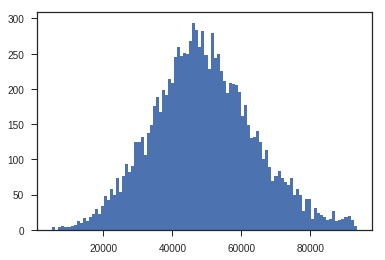

In [10]:
plt.hist(nn_train['1_'], 100)

### Actual filtering

In [40]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"]+1,axis=0)):
    numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(processed[processed["aliasNum"]==i]["numberLikes"])/len(processed[processed["aliasNum"]==i]))
    processed.loc[processed["aliasNum"]==i, 'mean']=avgLikes[i]
    #if (avgLikes[i]<20000000 and processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0]<1000000000):
    selection=np.append(selection, i)

In [6]:
processed.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes,aliasNum,ratio
count,16539.00,16539.00,16539.00,16539.00,16539.00,16539.00
mean,2315.73,2590.56,997829.41,24414.26,485.94,24414.26
std,2655.38,59090.66,1934400.77,64220.60,280.86,61676.81
min,15.00,0.00,124965.00,0.00,0.00,110.87
25%,787.00,191.00,198039.00,3232.50,243.00,3594.76
50%,1481.00,396.00,393843.00,7351.00,486.00,7678.65
75%,2932.00,645.00,935310.00,18357.00,729.00,18718.94
max,27671.00,1838511.00,22130730.00,1115123.00,972.00,875806.41


# Concatenate nlp

In [205]:
processed = pd.concat([processed, nlp], axis=1)

# Filtered version

In [41]:
filtered=processed[processed['aliasNum'].isin(selection)]
filtered.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes,aliasNum,mean
count,16539.00,16539.00,16539.00,16539.00,16539.00,16539.00
mean,2315.73,2590.56,997829.41,24414.26,485.94,24414.26
std,2655.38,59090.66,1934400.77,64220.60,280.86,61676.81
min,15.00,0.00,124965.00,0.00,0.00,110.87
25%,787.00,191.00,198039.00,3232.50,243.00,3594.76
50%,1481.00,396.00,393843.00,7351.00,486.00,7678.65
75%,2932.00,645.00,935310.00,18357.00,729.00,18718.94
max,27671.00,1838511.00,22130730.00,1115123.00,972.00,875806.41


# Feature extraction

In [42]:
modified = filtered.drop(["alias"],axis=1)
modified = modified.reset_index(drop=True)

### Website

In [43]:
modified['you']=modified['website'].str.contains("youtube|youtu", na=False).astype(int)
modified['music']=modified['website'].str.contains("soundcloud|spoti", na=False).astype(int)
modified['tumblr']=modified['website'].str.contains("tumblr", na=False).astype(int)
modified['facebook']=modified['website'].str.contains("facebook", na=False).astype(int)
modified['blog']=modified['website'].str.contains("blog|wordpress", na=False).astype(int)
modified['twitter']=modified['website'].str.contains("twitter", na=False).astype(int)
modified['other']=modified['website'].str.contains(".", na=False).astype(int)

modified = modified.drop(['website'], axis=1)

### Multiple image to int

In [44]:
modified['multipleImage']=modified['multipleImage'].astype(int)

### Convert days to days of week

In [45]:
copy=modified["date"].copy()
for i in range(0, len(modified)):
    copy[i] = datetime.weekday((dateutil.parser.parse(modified["date"][i])))
modified["date"]=copy.astype(np.int64)

modified['mon']=(modified['date']==0).astype(int)
modified['tue']=(modified['date']==1).astype(int)
modified['wed']=(modified['date']==2).astype(int)
modified['thu']=(modified['date']==3).astype(int)
modified['fri']=(modified['date']==4).astype(int)
modified['sat']=(modified['date']==5).astype(int)
modified['sun']=(modified['date']==6).astype(int)

modified = modified.drop(['date'], axis=1)

In [31]:
modified

,numberPosts,numberFollowing,numberFollowers,multipleImage,numberLikes,aliasNum,ratio,you,music,tumblr,...,blog,twitter,other,mon,tue,wed,thu,fri,sat,sun
0,988,233,720979,0,10047,0,23400.94,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,988,233,720979,0,16781,0,23400.94,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,988,233,720979,0,11227,0,23400.94,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,988,233,720979,0,21539,0,23400.94,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,988,233,720979,0,21054,0,23400.94,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5,988,233,720979,0,12375,0,23400.94,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,988,233,720979,0,15335,0,23400.94,0,0,0,...,0,0,1,0,0,0,0,1,0,0
7,988,233,720979,0,29161,0,23400.94,0,0,0,...,0,0,1,0,0,0,0,1,0,0
8,988,233,720979,0,10267,0,23400.94,0,0,0,...,0,0,1,0,0,0,0,1,0,0
9,988,233,720979,0,29776,0,23400.94,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [46]:
deleted=modified[modified["aliasNum"].astype(int)==0][0:2]
test=modified[modified["aliasNum"].astype(int)==0][3:6]
train=modified[modified["aliasNum"].astype(int)==0][6:len(modified[modified["aliasNum"].astype(int)==0])]

for i in range(1,np.max(modified["aliasNum"].astype(int),axis=0)):
#for i in range(0,10):
    deleted = pd.concat([deleted, modified[modified["aliasNum"]==i][0:2]], axis=0)
    test = pd.concat([test, modified[modified["aliasNum"]==i][3:6]], axis=0)
    train = pd.concat([train, modified[modified["aliasNum"]==i][6:len(modified[modified["aliasNum"]==i])]], axis=0)

In [47]:
X_train = train
X_test = test

In [18]:
#X_train = train.drop(['numberLikes'],axis=1)
#X_train = X_train.drop(['ratio'],axis=1)

y_train = train['numberLikes']

#X_test = test.drop(['numberLikes'],axis=1)
#X_test = X_test.drop(['ratio'],axis=1)
y_test = test['numberLikes']

### Add NN features

In [262]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

X_train = pd.concat([X_train, nn_train], axis=1)
X_test = pd.concat([X_test, nn_test], axis=1)

In [62]:
modified.shape

(16520, 556)

In [20]:
X_train

,numberPosts,numberFollowing,numberFollowers,multipleImage,aliasNum,ratio,you,music,tumblr,facebook,blog,twitter,other,mon,tue,wed,thu,fri,sat,sun
6,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,0,0,1,0,0
7,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,0,0,1,0,0
9,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,0,1,0,0,0
10,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,1,0,0,0,0
11,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,0,0,0,0,1
12,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,0,0,0,1,0
13,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,0,1,0,0,0
14,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,1,0,0,0,0
15,988,233,720979,0,0,23400.94,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [48]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"],axis=0)):
    print(i)
    #numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(X_train[X_train["aliasNum"]==i]["numberLikes"])/len(X_train[X_train["aliasNum"]==i]))
    X_train.loc[X_train["aliasNum"]==i, 'mean']=avgLikes[i]
    if (avgLikes[i]<200000 and X_train[X_train["aliasNum"]==i]['numberFollowers'].iloc[0]<1000000):
        selection=np.append(selection, i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [49]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"],axis=0)):
    print(i)
    #numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(X_test[X_test["aliasNum"]==i]["numberLikes"])/len(X_test[X_test["aliasNum"]==i]))
    X_test.loc[X_test["aliasNum"]==i, 'mean']=avgLikes[i]
    if (avgLikes[i]<200000 and X_test[X_test["aliasNum"]==i]['numberFollowers'].iloc[0]<1000000):
        selection=np.append(selection, i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [50]:
X_train=X_train[X_train['aliasNum'].isin(selection)]
X_test=X_test[X_test['aliasNum'].isin(selection)]

y_train = X_train['numberLikes']
X_train = X_train.drop(['numberLikes'],axis=1)

y_test = X_test['numberLikes']
X_test = X_test.drop(['numberLikes'],axis=1)

In [51]:
model_xgb = xgb.XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=596)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(RMSE)

2876.17275047


In [52]:
X_train

,numberPosts,numberFollowing,numberFollowers,multipleImage,aliasNum,mean,you,music,tumblr,facebook,blog,twitter,other,mon,tue,wed,thu,fri,sat,sun
6,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,0,0,1,0,0
7,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,0,0,1,0,0
9,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,0,1,0,0,0
10,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,1,0,0,0,0
11,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,0,0,0,0,1
12,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,0,0,0,1,0
13,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,0,1,0,0,0
14,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,1,0,0,0,0
15,988,233,720979,0,0,27708.45,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [53]:
model_xgb.score(X_test,y_test)

0.91747597736790809

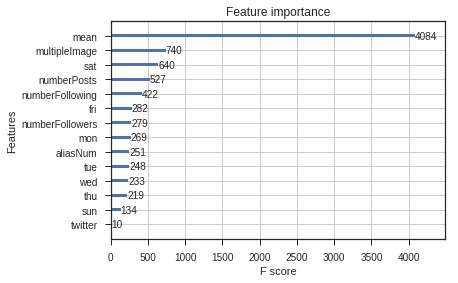

In [54]:
xgb.plot_importance(model_xgb, importance_type='weight') # weight, gain or cover

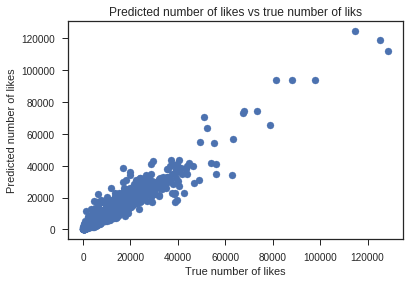

In [44]:
plt.scatter(y_test, y_pred)
plt.title('Predicted number of likes vs true number of liks')
plt.xlabel('True number of likes') 
plt.ylabel('Predicted number of likes') 
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

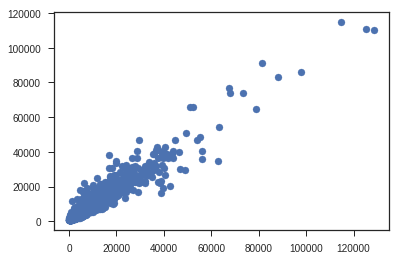

In [222]:
plt.scatter(y_test, y_pred)
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

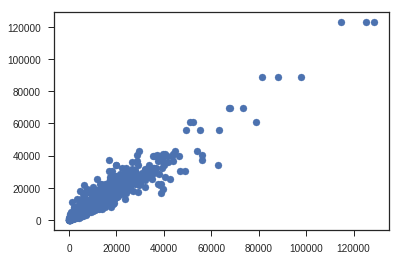

In [223]:
plt.scatter(y_test, X_test['ratio'])
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

### Test vs residuals

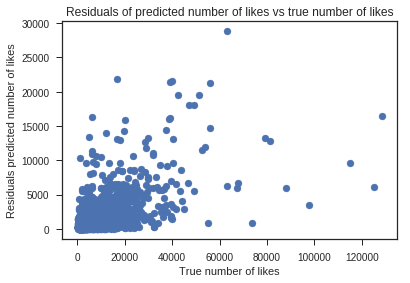

In [48]:
plt.scatter(y_test, abs(y_pred-y_test))
plt.title('Residuals of predicted number of likes vs true number of likes')
plt.xlabel('True number of likes') 
plt.ylabel('Residuals predicted number of likes') 

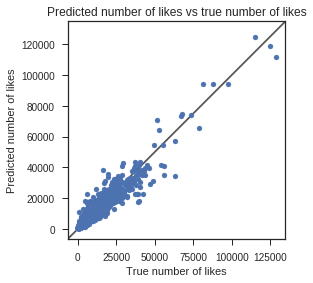

In [47]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_title('Predicted number of likes vs true number of likes')
ax.set_xlabel('True number of likes') 
ax.set_ylabel('Predicted number of likes') 

plt.show()

In [272]:
def score(params):
    global best2
    global count
    count=count+1
    print(count)
    num_round = int(params['n_estimators'])
    del(params['n_estimators'])
    #params['n_estimators']=num_round
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = mean_squared_error(y_test, predictions)**0.5
    
    if (score<best2):
        best2=score
        print(params)
        print(num_round)
        print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [275]:
def optimize():
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.005, 0.05, 0.005),
             'max_depth' : hp.choice('max_depth', np.arange(3, dtype=int)),
             #'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
            #'subsample' : hp.quniform('subsample', 0.6, 0.9, 0.05),
            # 'gamma' : hp.quniform('gamma', 0.6, 0.8, 0.05),
            #'colsample_bytree' : hp.quniform('colsample_bytree', 0.7, 1, 0.05),
              'reg_alpha' : hp.quniform('reg_alpha', 0.001, 10, 0.01),
             'reg_lambda' : hp.quniform('reg_lambda', 0.001, 10, 0.01),
             }

    best = fmin(score, space, algo=tpe.suggest, max_evals=50)

    print(best)

In [276]:
best2=100000
count=0
optimize()

1
{'reg_alpha': 3.85, 'max_depth': 2, 'learning_rate': 0.04, 'reg_lambda': 2.73}
738
	Score 2878.843115366204


2
3
{'reg_alpha': 3.08, 'max_depth': 2, 'learning_rate': 0.03, 'reg_lambda': 3.4}
269
	Score 2838.4748048833094


4
5
6
7
8
9
10
11
12
13
14
15
16
17
{'reg_alpha': 0.64, 'max_depth': 1, 'learning_rate': 0.045, 'reg_lambda': 9.34}
846
	Score 2829.4347073177146


18
19
20
21
22
23
{'reg_alpha': 9.36, 'max_depth': 1, 'learning_rate': 0.05, 'reg_lambda': 7.97}
999
	Score 2829.3348753024943


24
{'reg_alpha': 9.41, 'max_depth': 1, 'learning_rate': 0.045, 'reg_lambda': 6.18}
989
	Score 2828.7588654623373


25
26
27
28
{'reg_alpha': 6.95, 'max_depth': 1, 'learning_rate': 0.04, 'reg_lambda': 5.04}
921
	Score 2828.4739245406463


29
{'reg_alpha': 6.44, 'max_depth': 1, 'learning_rate': 0.04, 'reg_lambda': 2.17}
887
	Score 2828.114320664143


30
{'reg_alpha': 5.7700000000000005, 'max_depth': 1, 'learning_rate': 0.035, 'reg_lambda': 2.11}
905
	Score 2827.771944013462


31
32
33
34
35
36
